# 使用卷积神经网络对分割好的车牌字符进行识别

In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image 
import os

### 存成tfrecord 文件

In [6]:
# 生成整型的属性
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


# 生成字符串属性
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [4]:
# 存储数字 + 字母，训练集
def save_to_train_tfrecord(path, name, rows=24, cols=48):
    writer = tf.python_io.TFRecordWriter(name)
    classes = os.listdir(path)
    classes.sort()
    for i, _i in enumerate(classes):
        img_list_path = path + '/' + _i
        
        
        for j in os.listdir(img_list_path):
            img_path = img_list_path + '/' + j
            

            img = Image.open(img_path).convert('L')
            img = np.array(img.resize((rows, cols)))
            img_raw = img.tostring()
            example = tf.train.Example(features=tf.train.Features(feature={

                'image_raw': _bytes_feature(img_raw),
                'label': _int64_feature(i)}))
            writer.write(example.SerializeToString())

    writer.close()

In [ ]:
save_to_train_tfrecord('./data', 'train.tfrecords')

### 生成柱状图

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
样本总数量： 14475


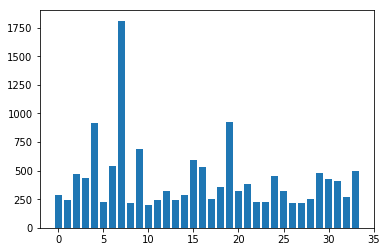

In [5]:
path = './data'
classes = os.listdir(path)
x = [i[0] for i in enumerate(classes)]
print(x)

data = []
for i in classes:
    # print(i, len(os.listdir(path + '/' + i)))
    data.append(len(os.listdir(path + '/' + i)))
print('样本总数量：', sum(data))
plt.bar(x, data)
plt.show()

### 生成饼图

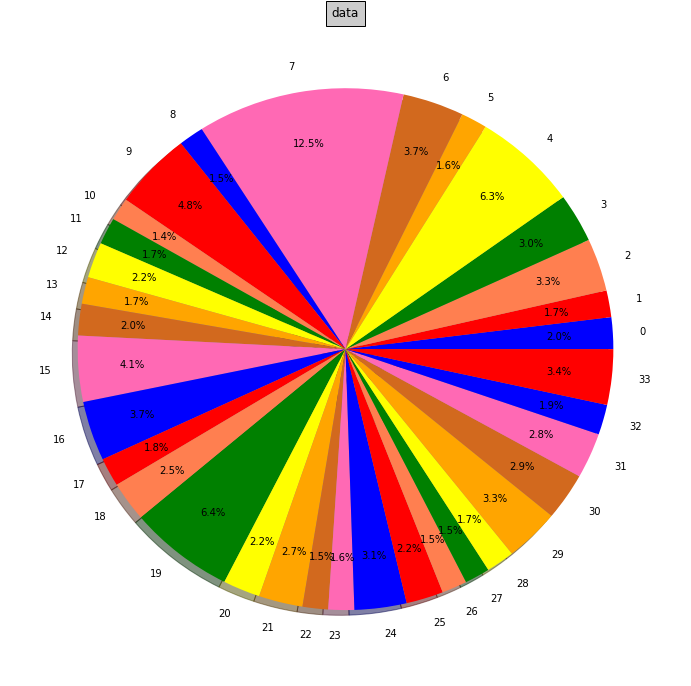

In [6]:
plt.figure(1, figsize=(12,12))    
expl = [0] * 34
  
colors  = ["blue","red","coral","green","yellow","orange", '#D2691E', '#FF69B4']  

plt.pie(data, explode=expl, colors=colors, labels=x, autopct='%1.1f%%',pctdistance=0.8, shadow=True)  
plt.title('data', bbox={'facecolor':'0.8', 'pad':6})  
plt.show()  

### 读取tfrecords 文件

In [2]:
def read_data(path):
    filename_queue = tf.train.string_input_producer([path]) 
    reader = tf.TFRecordReader()
    _, example = reader.read(filename_queue)
    features = tf.parse_single_example(
        example,
        features={
            'image_raw': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64),
        })

    images = tf.decode_raw(features['image_raw'], tf.uint8)
    images = tf.reshape(images, [1152])
    labels = tf.cast(features['label'], tf.int64) 
    
    return images/255, labels 


### 构建模型

In [3]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.1))


def init_bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))


with tf.Graph().as_default() as g:
    x_ = tf.placeholder(tf.float32, [None, 1152], name='image')
    y = tf.placeholder(tf.float32, [None, 34], 'label')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    x = tf.reshape(x_, [-1, 48, 24, 1], name='x')

    # 第一层卷积
    w1 = init_weights([3, 3, 1, 32])
    b1 = init_bias([32])
    conv1 = tf.nn.relu(tf.nn.conv2d(x, w1,  strides=[1, 1, 1, 1], padding='SAME') + b1)  # shape=(?, 48, 24, 32)
    # 池化
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # # shape=(?, 24, 12, 32)

    # 第二层卷积
    w2 = init_weights([3, 3, 32, 64])
    b2 = init_bias([64])
    conv2 = tf.nn.relu(tf.nn.conv2d(pool1, w2,  strides=[1, 1, 1, 1], padding='SAME') + b2)  # shape=(?, 24, 12, 64)
    # 池化
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # shape=(?, 12, 6, 64)

    # 第三层卷积
    w3 = init_weights([3, 3, 64, 96])
    b3 = init_bias([96])
    conv3 = tf.nn.relu(tf.nn.conv2d(pool2, w3,  strides=[1, 1, 1, 1], padding='SAME') + b3)  # shape=(?, 12, 6, 96)
    # 池化
    pool3_ = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # shape=(?, 6, 3, 96)

    pool3 = tf.reshape(pool3_, [-1, 6*3*96])

    # 全连接层
    w4 = init_weights([6 * 3 * 96, 512])
    b4 = init_bias([512])
    h = tf.nn.relu(tf.matmul(pool3, w4) + b4)

    h = tf.nn.dropout(h, keep_prob)

    # 输出层
    w_o = init_weights([512, 34])
    b_o = init_bias([34])
    # y_o = tf.nn.softmax(tf.matmul(h, w_o) + b_o)
    y_o = tf.matmul(h, w_o) + b_o

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_o, labels=y))
    # cost = -tf.reduce_sum(y*tf.log(y_o))
    train_op = tf.train.AdamOptimizer().minimize(cost)
    prediction = tf.equal(tf.argmax(y_o, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32), name='accuracy')
    saver = tf.train.Saver() 
    

In [5]:
with tf.Session(graph=g) as sess:
    # 读取数据
    img, label = read_data('train.tfrecords')
    batch_size = 200
    test_size = 256
    
     
    train_img, train_label = tf.train.shuffle_batch([img,label], batch_size=14475, capacity=2000, 
                                                    min_after_dequeue=1000, num_threads=2)
    train_label = tf.contrib.slim.one_hot_encoding(train_label, 34)

    val_img, val_label = tf.train.shuffle_batch([img,label], batch_size=200, capacity=2000, 
                                                    min_after_dequeue=1000, num_threads=2) 
    val_label = tf.contrib.slim.one_hot_encoding(val_label, 34) 
    
    
    
    sess.run(tf.global_variables_initializer())
    

    coord = tf.train.Coordinator()
    thread = tf.train.start_queue_runners(sess=sess, coord=coord)
    train_img, train_label = sess.run([train_img, train_label])
    d = dict()
    for i in range(20):
        training_batch = zip(range(0, len(train_img), batch_size),
                             range(batch_size, len(train_img)+1, batch_size))
        for start, end in training_batch:


            train_accuracy, loss, _, p, c = sess.run(
                [accuracy, cost, train_op, prediction, tf.argmax(y, 1)],
                feed_dict={x_: train_img[start: end], y: train_label[start: end], keep_prob: 1.0})
            train_op.run(feed_dict={x_: train_img[start: end], y: train_label[start: end], keep_prob: 0.8})
        
            
        # 验证集
        # val_accuracy = sess.run(feed_dict={x_: val_img, y: val_label, keep_prob: 1.0})

        # print("step %d, accuracy: %g, loss : %g" % (i, train_accuracy, loss)) 
        # print('val_accurary:' val_accuracy)
            for j in range(len(p)):

                if c[j] in d:
                    if p[j]:
                        d[c[j]][0] += 1
                        d[c[j]][1] += 1
                    else:
                        d[c[j]][1] += 1
                else:
                    if p[j]:
                        d[c[j]] = [1, 1]
                    else:
                        d[c[j]] = [0, 1] 
        print("step %d, accuracy: %g, loss : %g" % (i, train_accuracy, loss)) 

    save_path = saver.save(sess, 'model.ckpt')
#     test_batch = zip(range(0, len(t_img), test_size),
#                              range(test_size, len(t_img)+1, test_size))
#     print(test_batch)
#     for start, end in test_batch:
       
#         a, p, c = sess.run([accuracy, prediction, tf.argmax(y, 1)], 
#                            feed_dict={x_: t_img[start: end], y: t_label[start: end], keep_prob: 1.0})
        

#         for j in range(len(p)):

#             if c[j] in d:
#                 if p[j]:
#                     d[c[j]][0] += 1
#                     d[c[j]][1] += 1
#                 else:
#                     d[c[j]][1] += 1
#             else:
#                 if p[j]:
#                     d[c[j]] = [1, 1]
#                 else:
#                     d[c[j]] = [0, 1]

#     print(a)
    for k in d:
        print(d[k][0], d[k][1])
        print(k, ':', d[k][0]/d[k][1])
    coord.request_stop()
    coord.join(thread)


step 0, accuracy: 0.24, loss : 2.53816
step 1, accuracy: 0.41, loss : 1.7543
step 2, accuracy: 0.86, loss : 0.567475
step 3, accuracy: 0.93, loss : 0.223215
step 4, accuracy: 0.965, loss : 0.142003
step 5, accuracy: 0.97, loss : 0.0777691
step 6, accuracy: 0.99, loss : 0.0459623
step 7, accuracy: 0.995, loss : 0.0303487
step 8, accuracy: 0.995, loss : 0.019142
step 9, accuracy: 0.995, loss : 0.0135899
step 10, accuracy: 0.995, loss : 0.0131075
step 11, accuracy: 0.995, loss : 0.0189286
step 12, accuracy: 0.995, loss : 0.0221825
step 13, accuracy: 0.99, loss : 0.0219548
step 14, accuracy: 0.995, loss : 0.0181439
step 15, accuracy: 0.995, loss : 0.0336646
step 16, accuracy: 0.995, loss : 0.0265804
step 17, accuracy: 0.99, loss : 0.0331364
step 18, accuracy: 0.995, loss : 0.0318741
step 19, accuracy: 1, loss : 0.0188415
13548 15240
0 : 0.8889763779527559
15336 16620
1 : 0.9227436823104693
11023 12140
2 : 0.9079901153212521
9440 10360
3 : 0.9111969111969112
6574 7420
4 : 0.8859838274932614

In [16]:


with tf.Graph().as_default() as g2:
    t_size = 2
    img_, label_ = read_data('test_num_letter.tfrecords') 
    t_img, t_label = tf.train.shuffle_batch([img_,label_], batch_size=4314, capacity=4000, 
                                                        min_after_dequeue=1000, num_threads=2) 
    t_label = tf.contrib.slim.one_hot_encoding(t_label, 34) 

    x_ = tf.placeholder(tf.float32, [None, 1152], name='image')
    y = tf.placeholder(tf.float32, [None, 34], 'label')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    x = tf.reshape(x_, [-1, 48, 24, 1], name='x')

    # 第一层卷积
    w1 = init_weights([3, 3, 1, 32])
    b1 = init_bias([32])
    conv1 = tf.nn.relu(tf.nn.conv2d(x, w1,  strides=[1, 1, 1, 1], padding='SAME') + b1)  # shape=(?, 48, 24, 32)
    # 池化
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # # shape=(?, 24, 12, 32)

    # 第二层卷积
    w2 = init_weights([3, 3, 32, 64])
    b2 = init_bias([64])
    conv2 = tf.nn.relu(tf.nn.conv2d(pool1, w2,  strides=[1, 1, 1, 1], padding='SAME') + b2)  # shape=(?, 24, 12, 64)
    # 池化
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # shape=(?, 12, 6, 64)

    # 第三层卷积
    w3 = init_weights([3, 3, 64, 96])
    b3 = init_bias([96])
    conv3 = tf.nn.relu(tf.nn.conv2d(pool2, w3,  strides=[1, 1, 1, 1], padding='SAME') + b3)  # shape=(?, 12, 6, 96)
    # 池化
    pool3_ = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  # shape=(?, 6, 3, 96)

    pool3 = tf.reshape(pool3_, [-1, 6*3*96])

    # 全连接层
    w4 = init_weights([6 * 3 * 96, 512])
    b4 = init_bias([512])
    h = tf.nn.relu(tf.matmul(pool3, w4) + b4)

    h = tf.nn.dropout(h, keep_prob)

    # 输出层
    w_o = init_weights([512, 34])
    b_o = init_bias([34])
    # y_o = tf.nn.softmax(tf.matmul(h, w_o) + b_o)
    y_o = tf.matmul(h, w_o) + b_o

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_o, labels=y))
    # cost = -tf.reduce_sum(y*tf.log(y_o))
    train_op = tf.train.AdamOptimizer().minimize(cost)
    prediction = tf.equal(tf.argmax(y_o, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32), name='accuracy')
    
    saver = tf.train.Saver()
with tf.Session(graph=g2) as sess1:
    sess1.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    thread = tf.train.start_queue_runners(sess=sess1, coord=coord)
    
    t_img, t_label = sess1.run([t_img, t_label]) 
    
    # saver = tf.train.import_meta_graph('model.ckpt.meta')
    
    ckpt = tf.train.get_checkpoint_state('./')
    saver.restore(sess1, ckpt.model_checkpoint_path) 
    t_batch = zip(range(0, len(t_img), t_size),
                             range(t_size, len(t_img)+1, t_size))
    d = dict()
    
    for start, end in t_batch:
        print(start, end)

        train_accuracy, p, c = sess1.run(
                [accuracy, prediction, tf.argmax(y, 1)],
                feed_dict={x_: t_img[start: end], y: t_label[start: end], keep_prob: 1.0})
        
        for j in range(len(p)):

                if c[j] in d:
                    if p[j]:
                        d[c[j]][0] += 1
                        d[c[j]][1] += 1
                    else:
                        d[c[j]][1] += 1
                else:
                    if p[j]:
                        d[c[j]] = [1, 1]
                    else:
                        d[c[j]] = [0, 1] 
        # print(train_accuracy)
    print(sum([d[x][0] for x in d])/sum([d[x][1] for x in d]))
    for k in d:
        print(d[k][0], d[k][1])
        print(k, ':', d[k][0]/d[k][1])
    coord.request_stop()
    coord.join(thread)

INFO:tensorflow:Restoring parameters from ./model.ckpt
0 2
2 4
4 6
6 8
8 10
10 12
12 14
14 16
16 18
18 20
20 22
22 24
24 26
26 28
28 30
30 32
32 34
34 36
36 38
38 40
40 42
42 44
44 46
46 48
48 50
50 52
52 54
54 56
56 58
58 60
60 62
62 64
64 66
66 68
68 70
70 72
72 74
74 76
76 78
78 80
80 82
82 84
84 86
86 88
88 90
90 92
92 94
94 96
96 98
98 100
100 102
102 104
104 106
106 108
108 110
110 112
112 114
114 116
116 118
118 120
120 122
122 124
124 126
126 128
128 130
130 132
132 134
134 136
136 138
138 140
140 142
142 144
144 146
146 148
148 150
150 152
152 154
154 156
156 158
158 160
160 162
162 164
164 166
166 168
168 170
170 172
172 174
174 176
176 178
178 180
180 182
182 184
184 186
186 188
188 190
190 192
192 194
194 196
196 198
198 200
200 202
202 204
204 206
206 208
208 210
210 212
212 214
214 216
216 218
218 220
220 222
222 224
224 226
226 228
228 230
230 232
232 234
234 236
236 238
238 240
240 242
242 244
244 246
246 248
248 250
250 252
252 254
254 256
256 258
258 260
260 262
262 2

1858 1860
1860 1862
1862 1864
1864 1866
1866 1868
1868 1870
1870 1872
1872 1874
1874 1876
1876 1878
1878 1880
1880 1882
1882 1884
1884 1886
1886 1888
1888 1890
1890 1892
1892 1894
1894 1896
1896 1898
1898 1900
1900 1902
1902 1904
1904 1906
1906 1908
1908 1910
1910 1912
1912 1914
1914 1916
1916 1918
1918 1920
1920 1922
1922 1924
1924 1926
1926 1928
1928 1930
1930 1932
1932 1934
1934 1936
1936 1938
1938 1940
1940 1942
1942 1944
1944 1946
1946 1948
1948 1950
1950 1952
1952 1954
1954 1956
1956 1958
1958 1960
1960 1962
1962 1964
1964 1966
1966 1968
1968 1970
1970 1972
1972 1974
1974 1976
1976 1978
1978 1980
1980 1982
1982 1984
1984 1986
1986 1988
1988 1990
1990 1992
1992 1994
1994 1996
1996 1998
1998 2000
2000 2002
2002 2004
2004 2006
2006 2008
2008 2010
2010 2012
2012 2014
2014 2016
2016 2018
2018 2020
2020 2022
2022 2024
2024 2026
2026 2028
2028 2030
2030 2032
2032 2034
2034 2036
2036 2038
2038 2040
2040 2042
2042 2044
2044 2046
2046 2048
2048 2050
2050 2052
2052 2054
2054 2056
2056 2058


3500 3502
3502 3504
3504 3506
3506 3508
3508 3510
3510 3512
3512 3514
3514 3516
3516 3518
3518 3520
3520 3522
3522 3524
3524 3526
3526 3528
3528 3530
3530 3532
3532 3534
3534 3536
3536 3538
3538 3540
3540 3542
3542 3544
3544 3546
3546 3548
3548 3550
3550 3552
3552 3554
3554 3556
3556 3558
3558 3560
3560 3562
3562 3564
3564 3566
3566 3568
3568 3570
3570 3572
3572 3574
3574 3576
3576 3578
3578 3580
3580 3582
3582 3584
3584 3586
3586 3588
3588 3590
3590 3592
3592 3594
3594 3596
3596 3598
3598 3600
3600 3602
3602 3604
3604 3606
3606 3608
3608 3610
3610 3612
3612 3614
3614 3616
3616 3618
3618 3620
3620 3622
3622 3624
3624 3626
3626 3628
3628 3630
3630 3632
3632 3634
3634 3636
3636 3638
3638 3640
3640 3642
3642 3644
3644 3646
3646 3648
3648 3650
3650 3652
3652 3654
3654 3656
3656 3658
3658 3660
3660 3662
3662 3664
3664 3666
3666 3668
3668 3670
3670 3672
3672 3674
3674 3676
3676 3678
3678 3680
3680 3682
3682 3684
3684 3686
3686 3688
3688 3690
3690 3692
3692 3694
3694 3696
3696 3698
3698 3700
